### Comparison to fits

Let's demonstrate how well gaspery does compared to a fit on synthetic RV data. For this tutorial, we will use AU Mic b and a strategy of observing once every night for 30 nights. Specifically, we want to compare the expected value for $\sigma_K$ to the uncertainty on the retrieved K from the fit. 

This tutorial was initially based off the Fitting a Mean and Modeling Frameworks tutorials from DFM's tinygp documentation: https://tinygp.readthedocs.io/en/stable/tutorials/means.html

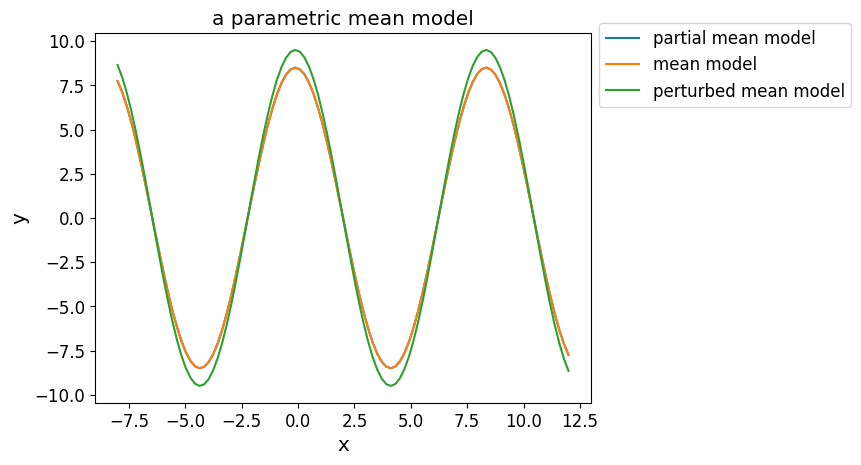

In [1]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import datetime
from numpy.linalg import inv, det, solve, cond

from gaspery import calculate_fi, strategies, utils
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)

path = '/Users/chris/Desktop/gaspery/'
random = np.random.default_rng(seed=4)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

def mean_function(params, X):
    
    return -params['K'] * jnp.sin(2 * jnp.pi * (X - params['T0']) / params['p'])

### AU Mic b parameters from Klein+ 
K = 8.5
p = 8.46
T0 = 2458651.993 - 2458650
theta = [8.5, 8.46, T0]

mean_params = {
    "K": K,
    "p": p,
    "T0": T0}

# save in back pocket to troubleshoot for overfitting
perturbed_mean_params = {
    "K": K+1.,
    "p": p,
    "T0": T0}

X_grid = np.linspace(T0 - 10, T0 + 10, 100)
# in Dan's tutorial, partial(mean) instead of mean is used. why? 
model = jax.vmap(partial(mean_function, mean_params))(X_grid) 

plt.plot(X_grid, model, label='partial mean model')
plt.plot(X_grid, mean_function(mean_params, X_grid), label='mean model')
plt.plot(X_grid, mean_function(perturbed_mean_params, X_grid), label='perturbed mean model')

plt.xlabel("x")
plt.ylabel("y")
plt.legend(bbox_to_anchor=(1., 1.05))
_ = plt.title("a parametric mean model")


Strategy

In [2]:
random = np.random.default_rng(seed=4) # formerly seed of 4

n_obs = 30
start = T0
offs = []

strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=4, twice_flag=False)) # off=p-1 :(; off=1.115 :)
print(strat)
#strat = strat + random.normal(0, 1./4, len(strat)) # formerly spread of 1./6 
#print(strat)

[  1.993   6.993  11.993  16.993  21.993  26.993  31.993  36.993  41.993
  46.993  51.993  56.993  61.993  66.993  71.993  76.993  81.993  86.993
  91.993  96.993 101.993 106.993 111.993 116.993 121.993 126.993 131.993
 136.993 141.993 146.993]


In [3]:
"""
random = np.random.default_rng(seed=4)

n_obs = 30
start = T0
offs = []

strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=1.115, twice_flag=False)) # in-quadrature
#strat = np.array(strategy.on_vs_off(on=1, off=p-1, twice_flag=False)) # trivial failure mode

# quadrature, extrema (troughs and peaks) only 
#strategy = strategies.Strategy(n_obs = n_obs, start = start+2.115, offs=offs, dropout=0.)
#strat = np.array(strategy.on_vs_off(on=1, off=p/2 - 1, twice_flag=False))  # 1.115*2
#print(strat)
"""

'\nrandom = np.random.default_rng(seed=4)\n\nn_obs = 30\nstart = T0\noffs = []\n\nstrategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)\nstrat = np.array(strategy.on_vs_off(on=1, off=1.115, twice_flag=False)) # in-quadrature\n#strat = np.array(strategy.on_vs_off(on=1, off=p-1, twice_flag=False)) # trivial failure mode\n\n# quadrature, extrema (troughs and peaks) only \n#strategy = strategies.Strategy(n_obs = n_obs, start = start+2.115, offs=offs, dropout=0.)\n#strat = np.array(strategy.on_vs_off(on=1, off=p/2 - 1, twice_flag=False))  # 1.115*2\n#print(strat)\n'

In past workflows, the finer grid modeling for plotting was drawn separately, but because I don’t know how to get the pseudorandom number generator to behave consistently for tinygp, I draw my training and validation points from a parent plotting grid of n*10 points, where n is the length in days of the observing strategy. 

In [4]:
# x_fine must pass through strat; this way, I can make it as fine as I want
### build x_fine as evenly spaced 
n = 10
x_fine = np.linspace(strat[0], strat[-1], int((strat[-1] - strat[0]) * n ) + 1)
print(x_fine[2]- x_fine[1])

### build x_fine as intrinsically random
# formerly ended with strat[-1], but then the ground truth becomes different each time bc the baseline changes
#x_fine = random.uniform(strat[0], strat[0]+250, 300) 

### concatenate strategy to x_fine
x_fine = np.concatenate((x_fine, strat))
x_fine = np.sort(x_fine)

0.10000000000000009


Star

In [5]:
random = np.random.default_rng(seed=4)

sigma_wn_rv = 5.
sigma_qp_rv = 47. #145 #47
Prot = 4.86
Tau = 110. # 30, 110
eta = 0.37

X = strat
# inject 20 random points in the time series and reserve for those to evaluate overfitting-ness
#X_injected = np.concatenate((strat, (random.uniform(1, 20)[0] * strat[-1]) + strat[0]), axis=0)
#X_injected = np.sort(np.concatenate((strat, random.uniform(strat[0], strat[-1], 30)), axis=0))
#X_injected = np.sort(np.concatenate((strat, random.choice(x_fine, 20)), axis=0))
#X_injectee = (np.random.rand(1, 20)[0] * strat[-1]) + strat[0]

In [6]:
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

Generate fake ground truth using the strategy, with 30 additional points, to use later for evaluation of overfitting by the MCMC. 

In [7]:
random = np.random.default_rng(seed=4)

planet_fine = calculate_fi.model_jax(x_fine, [theta[0], theta[1], theta[2]])
gp_fine = GaussianProcess(kernel, x_fine) 
star_fine = gp_fine.sample(jax.random.PRNGKey(4), shape=(1,)) 
observed_fine = star_fine + planet_fine + random.normal(0, sigma_wn_rv, len(planet_fine))

# assemble parent DataFrame, and split into training and validation sets
df_fine = pd.DataFrame({'x': x_fine, 'y': observed_fine[0], 
                            'planet': planet_fine, 'star': star_fine[0]})
df_fine = df_fine.drop_duplicates(subset=['x'])

not_injected = df_fine.loc[df_fine.x.isin(strat)]
#planet_strat = calculate_fi.model_jax(X, [theta[0], theta[1], theta[2]])
#gp_strat = GaussianProcess(kernel, X) 
#star_strat = gp_strat.sample(jax.random.PRNGKey(4), shape=(1,)) 
#observed_strat = star_strat + planet_strat + random.normal(0, sigma_wn_rv, len(planet_strat))
#df_strat = pd.DataFrame({'x': X, 'y': observed_strat[0], 
#                            'planet': planet_strat, 'star': star_strat[0]})
#not_injected = df_strat

injected_x = random.choice(x_fine, 30, replace=False)

injected = df_fine.loc[df_fine.x.isin(injected_x)]

What do the training and validation points look like, compared to the model from which they were drawn?

/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_13849/2866591876.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(not_injected.x, not_injected.y, yerr, fmt=".k", capsize=0, color='k', label='strategy')
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_13849/2866591876.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(injected.x, injected.y, yerr, fmt=".k", capsize=0, color='r', label='injected')


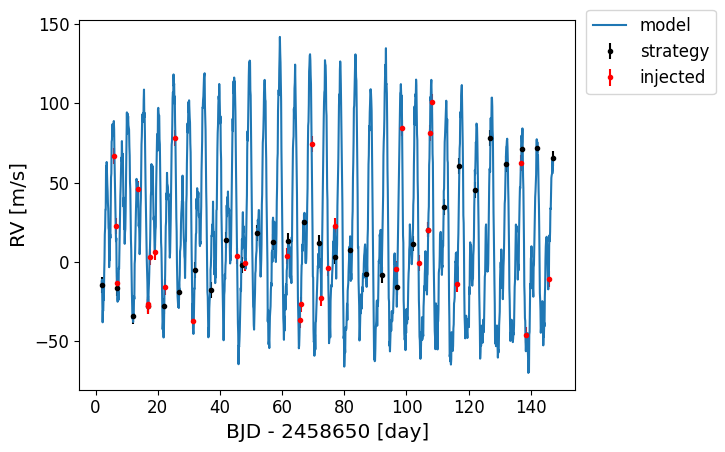

In [8]:
yerr = sigma_wn_rv

#plt.scatter(not_injected.x, not_injected.y, label='strategy')
#plt.scatter(injected.x, injected.y, label='injected')
plt.errorbar(not_injected.x, not_injected.y, yerr, fmt=".k", capsize=0, color='k', label='strategy')
plt.errorbar(injected.x, injected.y, yerr, fmt=".k", capsize=0, color='r', label='injected')

### also plot the model from which I sample everything. use fine grid, x_fine
#planet_fine = calculate_fi.model_jax(x_fine, [theta[0], theta[1], theta[2]])
#gp_fine = GaussianProcess(kernel, x_fine) 
#star_fine = gp_fine.sample(jax.random.PRNGKey(4), shape=(1,)) 
#observed_fine = star_fine + planet_fine + random.normal(0, sigma_wn_rv, len(planet_fine))
plt.plot(x_fine, observed_fine[0], label='model')
#plt.plot(x_fine, observed_fine[0] - np.median(observed_fine[0]) + np.median(injected_df.y), label='model')

plt.xlabel("BJD - 2458650 [day]")
plt.ylabel("RV [m/s]")

#plt.xlim([0, 50])
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

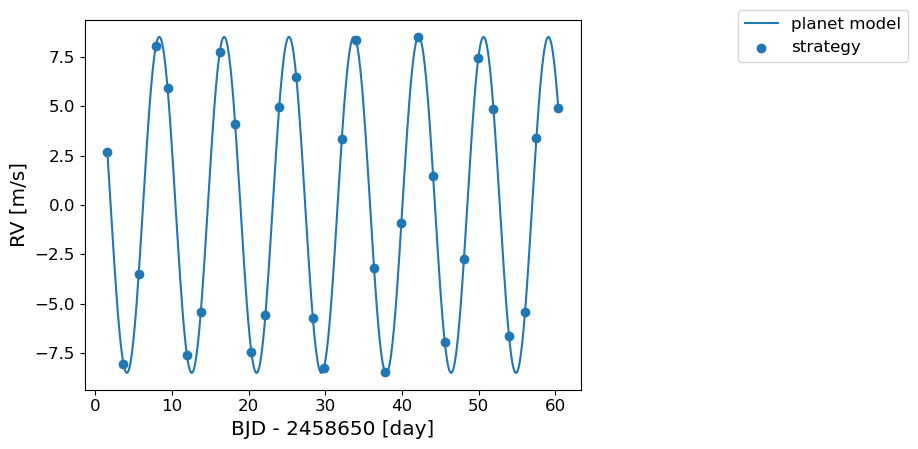

In [341]:
plt.plot(x_fine, planet_fine, label='planet model')
plt.scatter(strat, mean_function(mean_params, strat), label='strategy')
#plt.plot(x_fine, observed_fine[0] - np.median(observed_fine[0]) + np.median(injected_df.y), label='model')

plt.xlabel("BJD - 2458650 [day]")
plt.ylabel("RV [m/s]")
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

#### Brief aside for in-quadrature strategy

In [9]:
random = np.random.default_rng(seed=4)

n_obs = 10
start = T0
offs = []

#strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
#strat = np.array(strategy.on_vs_off(on=1, off=1.115, twice_flag=False)) # in-quadrature
#strat = np.array(strategy.on_vs_off(on=1, off=p-1, twice_flag=False)) # trivial failure mode

# quadrature, extrema (troughs and peaks) only 
strategy = strategies.Strategy(n_obs = n_obs, start = start+2.115, offs=offs, dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=p/2 - 1, twice_flag=False))  # 1.115*2

strat = np.sort(np.concatenate((strat, strat-0.5, strat+0.5)))
print(strat)



[ 3.608  4.108  4.608  7.838  8.338  8.838 12.068 12.568 13.068 16.298
 16.798 17.298 20.528 21.028 21.528 24.758 25.258 25.758 28.988 29.488
 29.988 33.218 33.718 34.218 37.448 37.948 38.448 41.678 42.178 42.678]


In [10]:
n = 10
x_fine = np.linspace(strat[0], strat[-1], int((strat[-1] - strat[0]) * n ) + 1)

x_fine = np.concatenate((x_fine, strat))
x_fine = np.sort(x_fine)

planet_fine = calculate_fi.model_jax(x_fine, [theta[0], theta[1], theta[2]])


In [11]:
strat[1]-strat[0]

0.5

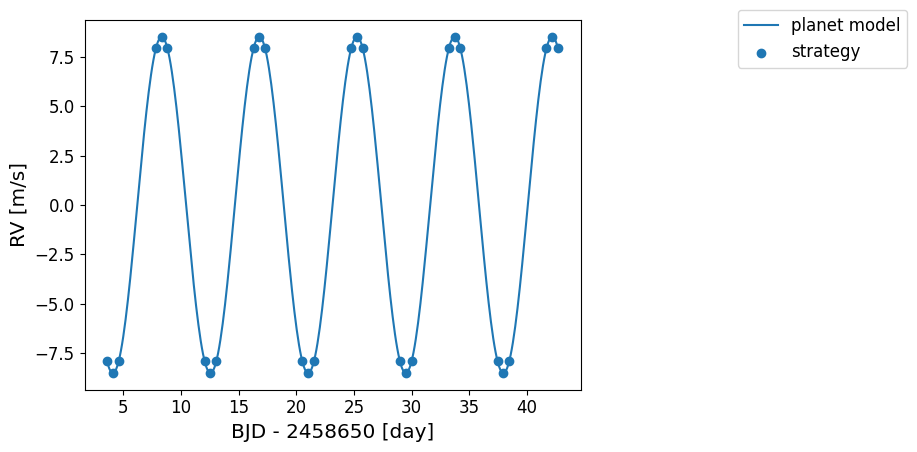

In [12]:
yerr = sigma_wn_rv

plt.plot(x_fine, planet_fine, label='planet model')
plt.scatter(strat, mean_function(mean_params, strat), label='strategy')
#plt.plot(x_fine, observed_fine[0] - np.median(observed_fine[0]) + np.median(injected_df.y), label='model')

plt.xlabel("BJD - 2458650 [day]")
plt.ylabel("RV [m/s]")
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

These paw print shapes are cute, but in order to fairly compare this strategy to the other ones we've been testing, we should randomize the points sampled around the troughs/peaks. 

30


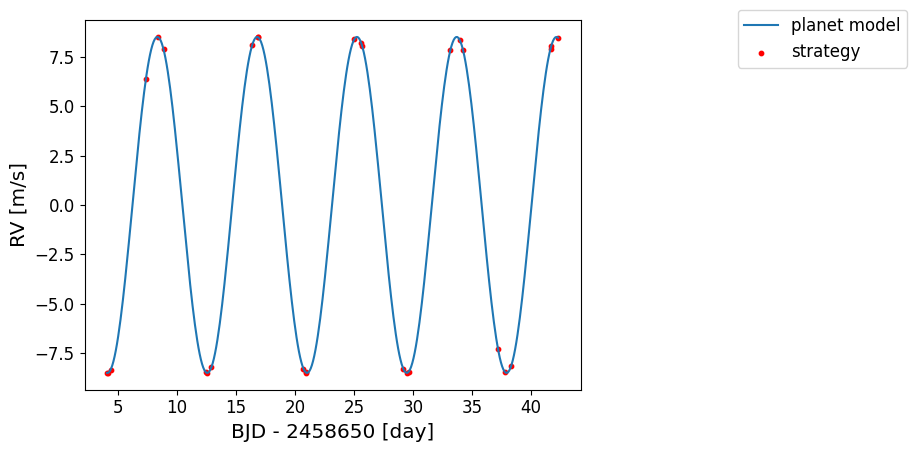

30


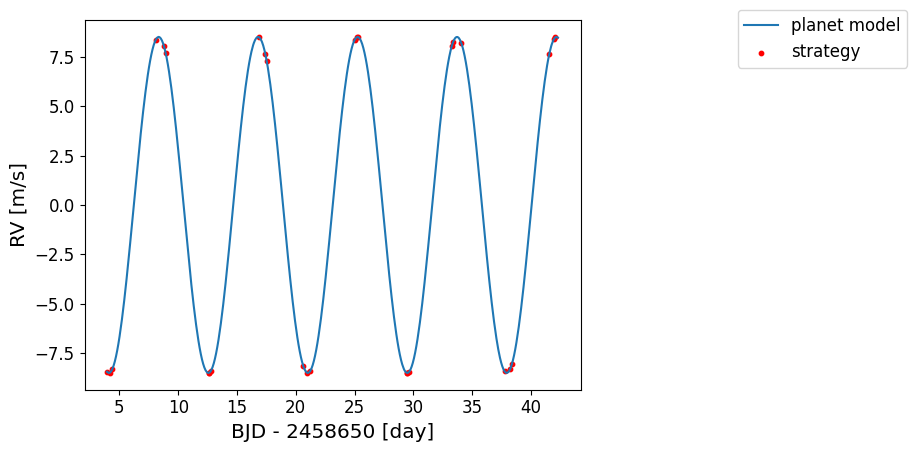

30


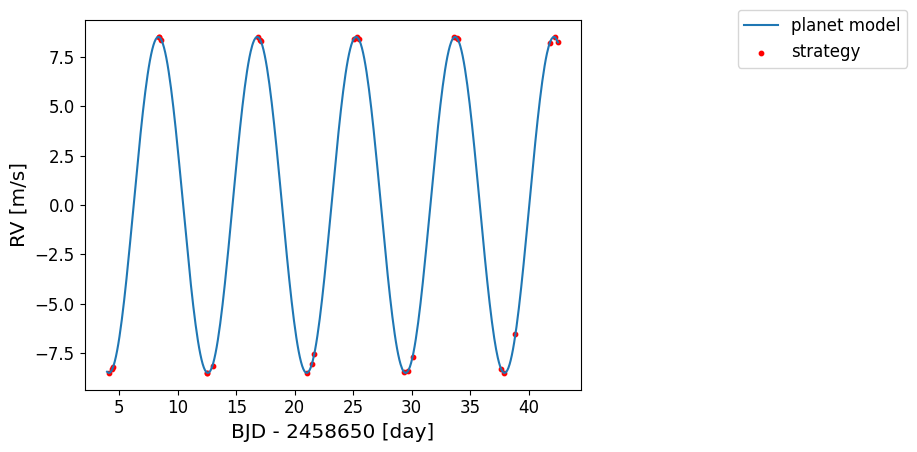

In [15]:
### strategy in quadrature
strategy = strategies.Strategy(n_obs = n_obs, start = start+2.115, offs=offs, dropout=0.) # usually start time is randomized, but this is fixed 
grid_strat = np.array(strategy.on_vs_off(on=1, off=p/2 - 1, twice_flag=False))  # 1.115*2
x_fine = np.linspace(grid_strat[0], grid_strat[-1], int((grid_strat[-1] - grid_strat[0]) * n ) + 1)

for i in range(3):
    strat = []
    for s in grid_strat:
        # draw three random times around each location of a trough or peak, with 2 hr spread
        strat.append(random.normal(loc=s, scale=1/3., size=3))
    strat = np.array(strat).ravel()

    # build x_fine as intrinsically random; concatenate strategy to x_fine
    x_fine = np.concatenate((x_fine, strat))
    x_fine = np.sort(x_fine)

    planet_fine = calculate_fi.model_jax(x_fine, [theta[0], theta[1], theta[2]])

    yerr = sigma_wn_rv
    print(len(strat))
    plt.plot(x_fine, planet_fine, label='planet model')
    plt.scatter(strat, mean_function(mean_params, strat), label='strategy', s=10, color='r')
    #plt.plot(x_fine, observed_fine[0] - np.median(observed_fine[0]) + np.median(injected_df.y), label='model')
    
    plt.xlabel("BJD - 2458650 [day]")
    plt.ylabel("RV [m/s]")
    plt.legend(bbox_to_anchor=(1.3, 1.05))
    plt.show()


A two-hour spread around the troughs and peaks still pretty much nails an exact-gridded in-quadrature strategy. 

#### Back to regular programming

A note on error: for this tutorial, yerr, or scatter, is a measurement uncertainty. Therefore, in this case, yerr can also be sigma_wn_rv. Generally, we probably should have added an extra "jitter" term, sampled from some probably normal distribution, to represent intrinsic scatter. But here, since we know the error budget exactly, we can set jitter to zero and the error bars to be the same size. That is, we are asserting in this case that every observation has the same number of photons.


Let's now calculate the expected value on $\sigma_K$ using a Fisher Information-based approach. Then, we'll compare this value to the uncertainty on the K retrieved by an MCMC fit. Note that this is agnostic of the data itself -- gaspery just cares about the times, not the y-values.

In [85]:
# instantiate gaspery Star object in order to feed covariance matrix with white/correlated noise
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

#strat = np.array(strategy.on_vs_off(on=1, off=0, twice_flag=False))
# calculate covariance matrix
sigma = star.cov_matrix_general(strat, kernel)

# populate arguments for Fisher Info calculator
args = np.array(strat), sigma, jnp.array(theta, dtype=float)

# calculate FI
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

# invert FI matrix
inv_fim = inv(fim)

# top left element of matrix corresponds with RV semi-amplitude, K
sigma_k = np.sqrt(inv_fim)[0][0]
print("expected value of uncertainty on K: ", sigma_k, " m/s")


expected value of uncertainty on K:  1.0316778778119386  m/s


/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_6922/2702598762.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


#### In the case of observing every other day, we should take another quick detour to see how the improvement on sigma_K relates to the size of the perturbation

/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_6922/1425720189.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


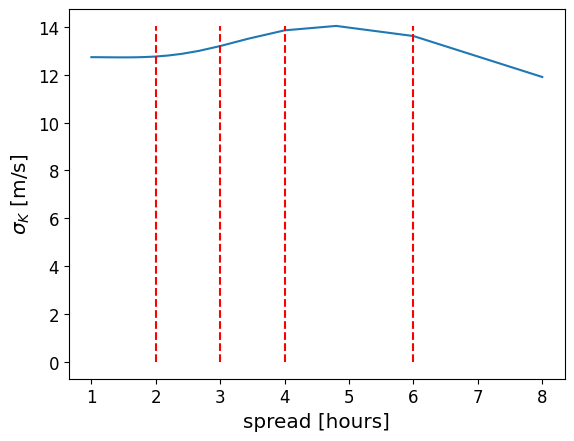

In [32]:
sigma_ks = []
for i in np.linspace(24., 3., 22):
    strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
    strat = np.array(strategy.on_vs_off(on=1, off=1, twice_flag=False)) # off=p-1 ??
    # introduce perturbation of varying size
    random = np.random.default_rng(seed=4)
    strat = strat + random.normal(0, 1./i, len(strat))
    X = strat
    #if i == 6.:
    #    print(X)
        
    # calculate covariance matrix
    sigma = star.cov_matrix_general(X, kernel)

    # populate arguments for Fisher Info calculator
    args = np.array(X), sigma, jnp.array(theta, dtype=float)

    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

    # invert FI matrix
    inv_fim = inv(fim)

    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    sigma_ks.append(sigma_k)
    #print(24./i, sigma_k, " m/s")
    
plt.plot(24/np.linspace(24., 3., 22), sigma_ks)
plt.xlabel('spread [hours]')
plt.ylabel(r'$\sigma_K$ [m/s]')
plt.vlines(2, 0, max(sigma_ks), linestyle='--', color='r')
plt.vlines(3, 0, max(sigma_ks), linestyle='--', color='r')
plt.vlines(4, 0, max(sigma_ks), linestyle='--', color='r')
plt.vlines(6, 0, max(sigma_ks), linestyle='--', color='r')

plt.show()

A 4-hour spread looks good enough!

### MCMC sampling

Framework for MCMC sampling, powered by numpyro. As you can see, a lot of extra bells and whistles are included in this framework, including ways to separately model the mean model (planet) and the stellar noise model, as well as to do inference on training and validation points separately. 

In [86]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def numpyro_model(t, y, yerr, hyperparams, theta, injected_x, not_injected_x, t_fine):        
        
    sigma_qp_rv = hyperparams[0]
    Prot = hyperparams[1]
    Tau = hyperparams[2]
    eta = hyperparams[3]
    
    K = theta[0]
    p = theta[1]
    T0 = theta[2]
    
    #t_plot = np.linspace(t[0], t[-1], 200) # create finer grid for plotting
    
    # sample hyperparameters using priors from Plavchan+ 2020, Table 1: https://arxiv.org/pdf/2006.13248.pdf
    #sigma_qp_rv = numpyro.sample("sigma_qp_rv", dist.Normal(sigma_qp_rv, 16)) #31./2))
    #Prot = numpyro.sample("Prot", dist.Normal(Prot, 0.01))
    #Tau = numpyro.sample("Tau", dist.TruncatedNormal(Tau, 30, low=0.)) # 110, 3
    #eta = numpyro.sample("eta", dist.Normal(eta, 0.02))
        
    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
    kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
    kernel *= sigma_qp_rv**2 # multiply by scalar
    
    # sample hyperparameters for planet mean model
    p = numpyro.sample("P", dist.Normal(p, 0.00004)) 
    K = numpyro.sample("K", dist.TruncatedNormal(0., 100., low=0.)) # formerly K, 2.25, but that's too informative
    #K = numpyro.sample("K", dist.Uniform(0., 100.))
    T0 = numpyro.sample("T0", dist.Normal(T0, 1))
    mean_params = {"K": K, "P": p, "T0": T0}
        
    def mean_function(t):
        """
        Mean model is the planet's Keplerian.
        """

        return -mean_params['K'] * jnp.sin(2 * jnp.pi * (t - mean_params['T0']) / mean_params['P'])
        
    gp = GaussianProcess(kernel, t, diag=yerr**2, mean=mean_function) # mean_function
    #gp_plot = GaussianProcess(kernel, t_plot, diag=yerr**2, mean=mean_function)
    
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)
    #numpyro.sample("gp_plot", gp_plot.numpyro_dist(), obs=y)
    
    if y is not None:
        # condition on y; evaluate on these three different time vectors
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc) # evaluate on each strat time 
        numpyro.deterministic("pred-plot", gp.condition(y, t_fine).gp.loc) # evaluate on finer strat time, for plots
        numpyro.deterministic("inj-rec", gp.condition(y, injected_x).gp.loc) # evaluate on injected times only
        
        # same but without including the mean, to separately evaluate planet and stellar fits
        numpyro.deterministic("pred-star", gp.condition(y, t, include_mean=False).gp.loc) 
        numpyro.deterministic("pred-plot-star", gp.condition(y, t_fine, include_mean=False).gp.loc) 
        numpyro.deterministic("inj-rec-star", gp.condition(y, injected_x, include_mean=False).gp.loc) 
        #numpyro.deterministic("training-star", gp.condition(y, not_injected_x, include_mean=False).gp.loc) 

    """
    ### compute inferences, separating the mean
    _, cond = gp.condition(y, t_plot, include_mean=False) # compute conditional distribution without the mean function
    _, cond_residual = gp.condition(y, not_injected_x, include_mean=False) # same but for residuals
    _, cond_residual_injected = gp.condition(y, injected_x, include_mean=False) # same but for residuals

    mu = cond.loc #+ soln.params["K"] # add mean model's zero point offset
    mu_residual = cond_residual.loc #+ soln.params["K"]
    mu_residual_injected = cond_residual_injected.loc #+ soln.params["K"]
    std = np.sqrt(cond.variance)
    std_residual = np.sqrt(cond_residual.variance)
    std_residual_injected = np.sqrt(cond_residual_injected.variance)
    
    return mu, mu_residual, mu_residual_injected, std, std_residual, std_residual_injected
    """
    #y_plot = jax.vmap(gp.mean_function)(t_plot)
    #return y_plot

nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000, # 1000
    num_samples=8000, # 5000
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(34923)

/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_6922/1469614892.py:80: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Prep ingredients for numpyro sampling framework. Hyperparams are the stellar parameters; theta are the planet parameters.

In [87]:
hyperparams = [sigma_qp_rv, Prot, Tau, eta]
theta = [K, p, T0] 
perturbed_theta = [K+1., p, T0]

In [88]:
hyperparams, theta

([47.0, 4.86, 110.0, 0.37], [8.5, 8.46, 1.9929999997839332])

Run the MCMC

In [89]:
start = datetime.datetime.now()

gp_output = mcmc.run(rng_key, t=np.array(not_injected.x), y=np.array(not_injected.y), yerr=sigma_wn_rv, # X, y vs t_plot, y_plot
         hyperparams=hyperparams, theta=theta, injected_x=np.array(injected.x), 
                     not_injected_x=np.array(not_injected.x), t_fine=x_fine)
samples = mcmc.get_samples()
#print(samples)

preds = samples["pred"].block_until_ready()  # Blocking to get timing right
preds_plot = samples["pred-plot"].block_until_ready()  
preds_star = samples["pred-star"].block_until_ready()  
preds_inj_rec = samples["inj-rec"].block_until_ready()  
preds_plot_star = samples["pred-plot-star"].block_until_ready()  
preds_inj_rec_star = samples["inj-rec-star"].block_until_ready()  
#preds_training_star = samples["training-star"].block_until_ready()  

end = datetime.datetime.now()
print("time elapsed: ", end-start)

sample: 100%|███████████████████████████████████████████████████████████████████████████| 9000/9000 [00:04<00:00, 1861.42it/s, 175 steps of size 1.04e-02. acc. prob=0.96]


time elapsed:  0:00:12.646044


Read out MCMC posteriors summary

In [90]:
import arviz as az

data = az.from_numpyro(mcmc)

print(data.posterior.data_vars['K'].mean())
print(data.posterior.data_vars['K'].std())

<xarray.DataArray 'K' ()>
array(7.90148319)
<xarray.DataArray 'K' ()>
array(1.29150198)


That was assuming Gaussian posteriors. Let's instead take the 16th, 50th, and 84th percentiles.

In [91]:
print(np.percentile(data.posterior.data_vars['K'], 84) - np.percentile(data.posterior.data_vars['K'], 50))
print(np.percentile(data.posterior.data_vars['K'], 50) - np.percentile(data.posterior.data_vars['K'], 16))
print(np.percentile(data.posterior.data_vars['K'], 50))
print("")
print(np.percentile(data.posterior.data_vars['T0'], 50))
print(np.percentile(data.posterior.data_vars['P'], 50))


1.2521403903758044
1.297654708896136
7.922460892836004

1.6109665791972736
8.460000924732533


In [79]:
"""
import arviz as az

data = az.from_numpyro(mcmc)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if (v != "pred") or (v != "pred-plot") or (v!="pred-star")]
)
"""

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
K,9.066,2.169,5.029,13.180,0.031,0.022,4910.0,3870.0,1.0
P,8.460,0.000,8.460,8.460,0.000,0.000,16085.0,11033.0,1.0
T0,2.439,0.718,1.029,3.747,0.010,0.007,5310.0,5427.0,1.0
inj-rec[0],9.999,1.723,6.721,13.203,0.026,0.018,4546.0,4918.0,1.0
inj-rec[1],-12.838,7.710,-26.324,1.948,0.108,0.076,5144.0,5264.0,1.0
...,...,...,...,...,...,...,...,...,...
pred-star[25],13.748,3.315,7.765,20.186,0.047,0.034,5061.0,5580.0,1.0
pred-star[26],-30.859,3.730,-37.909,-24.218,0.053,0.038,5104.0,5221.0,1.0
pred-star[27],-9.610,3.046,-15.528,-4.102,0.044,0.032,4888.0,5528.0,1.0
pred-star[28],-35.926,3.979,-43.026,-28.383,0.055,0.039,5186.0,5259.0,1.0


In [37]:
K, p, T0

(8.5, 8.46, 1.9929999997839332)

Plot the trace!

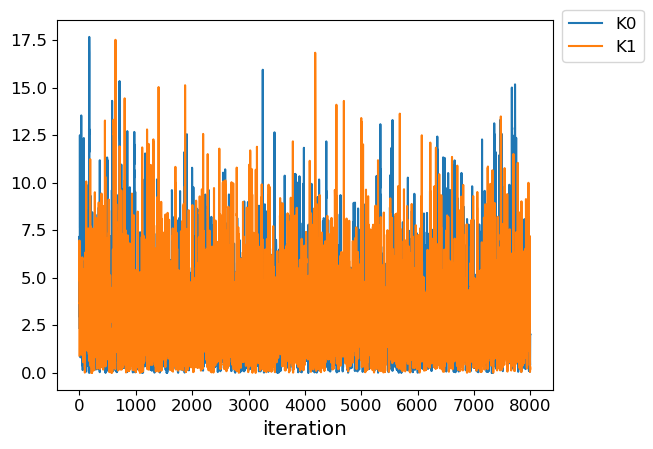

In [294]:
plt.plot(data.posterior.data_vars['K'][0], label='K0')
plt.plot(data.posterior.data_vars['K'][1], label='K1')
#plt.plot(data.posterior.data_vars['K'][2], label='K2')
#plt.plot(data.posterior.data_vars['K'][3], label='K3')

#plt.plot(data.posterior.data_vars['P'][0], label='P')
#plt.plot(data.posterior.data_vars['T0'][0], label='T0')
plt.xlabel('iteration')
plt.legend(bbox_to_anchor=(1.2, 1.05))
#plt.savefig(path+'plots/trace_bad_normal.png')
plt.show()

Time for corner plots!

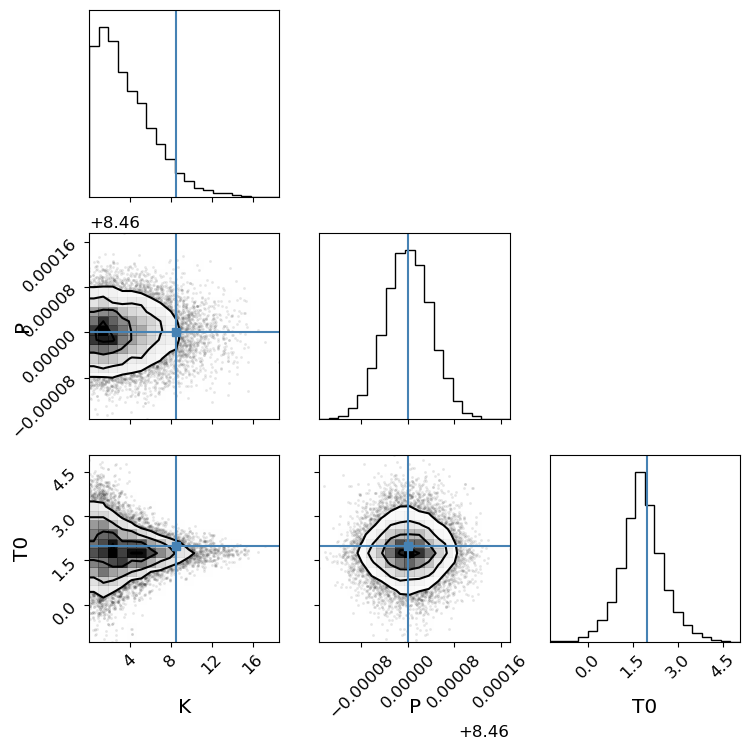

In [331]:
import corner 

#corner.corner(data, var_names=["K", "P", "T0", "sigma_qp_rv", "Prot", "Tau", "eta"], 
#              truths=[K, p, T0, sigma_qp_rv, Prot, Tau, eta])
corner.corner(data, var_names=["K", "P", "T0"], truths=[K, p, T0]);
plt.tight_layout()
#plt.savefig(path+'plots/corner_bad_normal.png')


Now we can finally plot the best-fit model against the data!

In [92]:
q = np.percentile(preds, [16, 50, 84], axis=0)
q_plot = np.percentile(preds_plot, [16, 50, 84], axis=0)
q_star = np.percentile(preds_star, [16, 50, 84], axis=0)
q_star_plot = np.percentile(preds_plot_star, [16, 50, 84], axis=0)
q_inj = np.percentile(preds_inj_rec, [16, 50, 84], axis=0)
q_inj_star = np.percentile(preds_inj_rec_star, [16, 50, 84], axis=0)

q_planet = q - q_star # 30
q_planet_plot = q_plot - q_star_plot # 200
q_planet_inj = q_inj - q_inj_star # 20

"""
plt.fill_between(x_fine, q_planet_plot[0], q_planet_plot[2], color="C0", alpha=0.5, label="inference")
plt.plot(x_fine, q_planet_plot[1], color="C0", lw=2)

#plt.errorbar(X, y, yerr, fmt=".k", capsize=0, label="data")

plt.scatter(X, not_injected.planet, label="training data", color="k", s=10)
plt.scatter(injected.x, injected.planet, label="injected data", color="red", s=10)
#plt.scatter(X_injected, sample_injected[0], label="activity", alpha=0.5, color="red", s=10)
###plt.fill_between(np.array(injected.x), q_injected[0], q_injected[2], color="green", alpha=0.5, label="injected")
#plt.errorbar(np.array(injected.x), np.array(injected.y), yerr, fmt=".k", color='r', capsize=0, label="injected data")

plt.xlabel("time [day]")
plt.ylabel("RV [m/s]")
plt.legend(bbox_to_anchor=(1.35, 1.05))
#_ = plt.title("best-fit, 30 observations, every day")
#plt.savefig(path+'plots/breakdown_30_obs_good.png')
plt.show()
"""

'\nplt.fill_between(x_fine, q_planet_plot[0], q_planet_plot[2], color="C0", alpha=0.5, label="inference")\nplt.plot(x_fine, q_planet_plot[1], color="C0", lw=2)\n\n#plt.errorbar(X, y, yerr, fmt=".k", capsize=0, label="data")\n\nplt.scatter(X, not_injected.planet, label="training data", color="k", s=10)\nplt.scatter(injected.x, injected.planet, label="injected data", color="red", s=10)\n#plt.scatter(X_injected, sample_injected[0], label="activity", alpha=0.5, color="red", s=10)\n###plt.fill_between(np.array(injected.x), q_injected[0], q_injected[2], color="green", alpha=0.5, label="injected")\n#plt.errorbar(np.array(injected.x), np.array(injected.y), yerr, fmt=".k", color=\'r\', capsize=0, label="injected data")\n\nplt.xlabel("time [day]")\nplt.ylabel("RV [m/s]")\nplt.legend(bbox_to_anchor=(1.35, 1.05))\n#_ = plt.title("best-fit, 30 observations, every day")\n#plt.savefig(path+\'plots/breakdown_30_obs_good.png\')\nplt.show()\n'

And we can plot the residuals...

In [93]:
### residuals
planet_training_residuals = not_injected.planet - q_planet[1]
planet_injected_residuals = injected.planet - q_planet_inj[1]
star_training_residuals = not_injected.star - q_star[1]
star_injected_residuals = injected.star - q_inj_star[1]

print("std planet residuals: ", np.std(planet_training_residuals))
print("std planet residuals, injected: ", np.std(planet_injected_residuals))

print("std star residuals: ", np.std(star_training_residuals))
print("std star residuals, injected: ", np.std(star_injected_residuals))

"""
plt.errorbar(X, star_training_residuals, yerr, fmt=".k", capsize=0, label="training residuals")
plt.errorbar(injected.x, star_injected_residuals, yerr, fmt=".k", color='r', capsize=0, label="injected residuals")

plt.xlabel("time [day]")
plt.ylabel("RV [m/s]")
plt.legend(bbox_to_anchor=(1.35, 1.05))
#_ = plt.title("best-fit, 30 observations, every day")
plt.show()


plt.scatter(X, planet_training_residuals, color="k", label="training residuals")
plt.scatter(injected.x, planet_injected_residuals, color='r', label="injected residuals")

plt.xlabel("time [day]")
plt.ylabel("RV [m/s]")
plt.legend(bbox_to_anchor=(1.35, 1.05))
#_ = plt.title("best-fit, 30 observations, every day")
plt.show()
"""


std planet residuals:  1.6838378794869324
std planet residuals, injected:  1.861938252387997
std star residuals:  2.3998591009451293
std star residuals, injected:  18.69501918130955


'\nplt.errorbar(X, star_training_residuals, yerr, fmt=".k", capsize=0, label="training residuals")\nplt.errorbar(injected.x, star_injected_residuals, yerr, fmt=".k", color=\'r\', capsize=0, label="injected residuals")\n\nplt.xlabel("time [day]")\nplt.ylabel("RV [m/s]")\nplt.legend(bbox_to_anchor=(1.35, 1.05))\n#_ = plt.title("best-fit, 30 observations, every day")\nplt.show()\n\n\nplt.scatter(X, planet_training_residuals, color="k", label="training residuals")\nplt.scatter(injected.x, planet_injected_residuals, color=\'r\', label="injected residuals")\n\nplt.xlabel("time [day]")\nplt.ylabel("RV [m/s]")\nplt.legend(bbox_to_anchor=(1.35, 1.05))\n#_ = plt.title("best-fit, 30 observations, every day")\nplt.show()\n'

Altogether...

In [ ]:
plt.scatter(X, np.array(not_injected.star), label='training data')
plt.scatter(X, q_star[1], label='training inference')
plt.legend()
plt.show()

plt.scatter(np.array(injected.x), np.array(injected.star), label='validation data')
plt.scatter(np.array(injected.x), q_inj_star[1], label='validation inference')
plt.legend()
plt.show()

plt.scatter(X, np.array(not_injected.star) - q_star[1], label='training residuals')
plt.legend()
plt.show()

plt.scatter(np.array(injected.x), np.array(injected.star) - q_inj_star[1], label='validation residuals')
plt.legend()
plt.show()

print("training residuals: ", np.std(np.array(not_injected.star) - q_star[1]))
print("validation residuals: ", np.std(np.array(injected.star) - q_inj_star[1]))

std stellar residuals:  2.3998591009451293
std stellar residuals, injected:  18.69501918130955
std planet residuals:  1.6838378794869324
std planet residuals, injected:  1.861938252387997
std residuals:  4.019457726653125
std residuals, injected:  19.898738593131206


/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_6922/1539996680.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax5.errorbar(np.array(injected.x), np.array(injected.y), yerr, color='r', fmt=".k", capsize=0, label="validation data")
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_6922/1539996680.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax3.errorbar(np.array(injected.x), res_injected, yerr, fmt=".k", capsize=0, label='injected combined', color='r')
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_6922/1539996680.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax3.errorbar(np.array(not_injected.x), res_

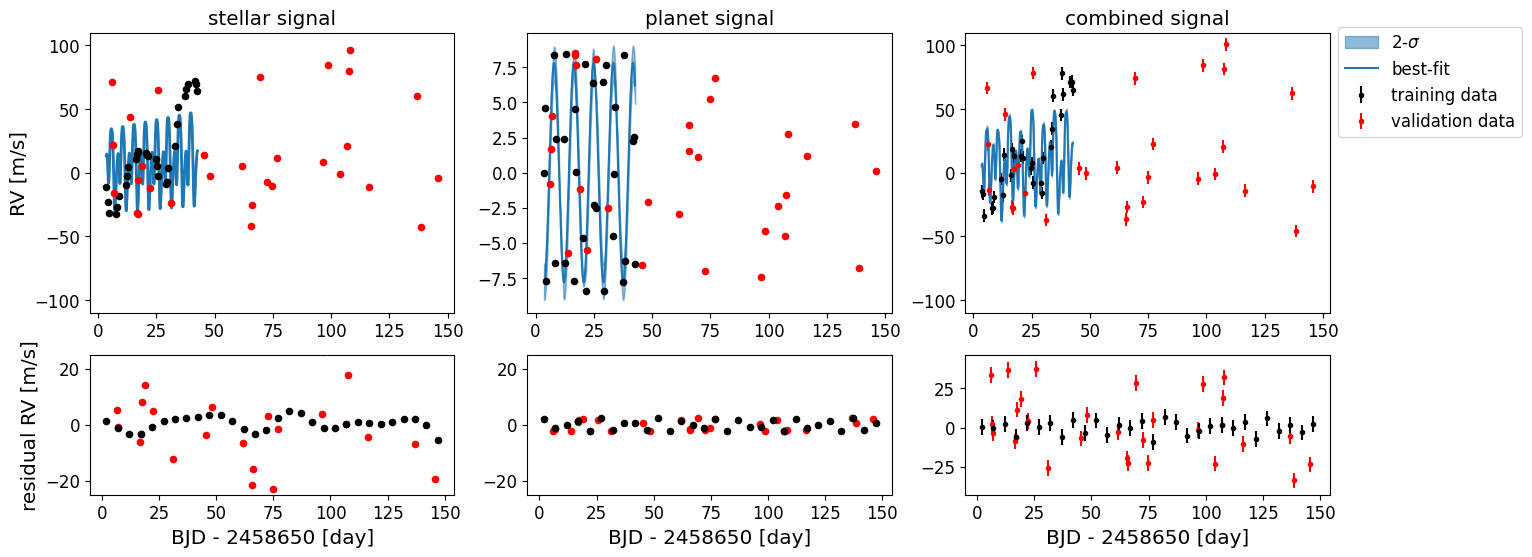

In [94]:
f, ((ax1, ax2, ax5), (ax6, ax4, ax3)) = plt.subplots(2, 3, figsize=(16, 6), height_ratios=[1, 0.5])

### plotting
# star
#ax1.plot(X_grid, q_star_plot, label="GP model")
#ax1.fill_between(X_grid, mu + std, mu - std, color="C0", alpha=0.3)
ax1.fill_between(x_fine, q_star_plot[0], q_star_plot[2], color="C0", alpha=0.3, label="GP model")
ax1.plot(x_fine, q_star_plot[1], color="C0", lw=2)
ax1.scatter(strat, np.array(not_injected.star), color='k', label="star data", s=20, zorder=3)
ax1.scatter(np.array(injected.x), np.array(injected.star), color='r', label="injected star data", s=20, zorder=3)
ax1.set_ylabel("RV [m/s]")
ax1.set_title("stellar signal")
ax1.set_ylim([-110, 110])

# star residuals
res_star_injected = injected.star - q_inj_star[1]
res_star_training = not_injected.star - q_star[1]
ax6.scatter(np.array(injected.x), res_star_injected, label='injected star', color='r', s=20, zorder=3)
ax6.scatter(np.array(not_injected.x), res_star_training, label='training star', color='k', s=20, zorder=3)
ax6.set_xlabel("BJD - 2458650 [day]")
ax6.set_ylabel("residual RV [m/s]")
ax6.set_ylim([-25, 25])
print("std stellar residuals: ", np.std(res_star_training))
print("std stellar residuals, injected: ", np.std(res_star_injected))

# planet
ax2.scatter(strat, np.array(not_injected.planet), color='k', label="fitted data", s=20, zorder=3)
ax2.scatter(np.array(injected.x), np.array(injected.planet), color='r', label="injected data", s=20, zorder=3)
ax2.fill_between(x_fine, q_planet_plot[0], q_planet_plot[2], color="C0", alpha=0.5, label="inference")
ax2.plot(x_fine, q_planet_plot[1], label="GP or mean model")

#theta_not_fine = [15.7, p, 2.31]
#planet_not_fine = calculate_fi.model_jax(x_fine, [theta_not_fine[0], theta_not_fine[1], theta_not_fine[2]])
#ax2.plot(x_fine, planet_not_fine, label="not ok")

ax2.set_title("planet signal")
#ax2.legend(bbox_to_anchor=(1., 1.05))

# planet residuals 
res_planet_injected = injected.planet - q_planet_inj[1]
res_planet_training = not_injected.planet - q_planet[1]
ax4.scatter(np.array(injected.x), res_planet_injected, label='injected planet', color='r', s=20, zorder=3)
ax4.scatter(np.array(not_injected.x), res_planet_training, label='training planet', color='k', s=20, zorder=3)
ax4.set_xlabel("BJD - 2458650 [day]")
ax4.set_ylim([-25, 25])
#ax4.legend(bbox_to_anchor=(1., 1.05))
print("std planet residuals: ", np.std(res_planet_training))
print("std planet residuals, injected: ", np.std(res_planet_injected))

# combined
ax5.errorbar(strat, np.array(not_injected.y), yerr, fmt=".k", capsize=0, label="training data")
ax5.errorbar(np.array(injected.x), np.array(injected.y), yerr, color='r', fmt=".k", capsize=0, label="validation data")
ax5.fill_between(x_fine, q_plot[0], q_plot[2], color="C0", alpha=0.5, label=r"2-$\sigma$")
ax5.plot(x_fine, q_plot[1], label="best-fit")
ax5.set_title("combined signal")
ax5.legend(bbox_to_anchor=(1., 1.05))
ax5.set_ylim([-110, 110])

# combined residuals 
res_injected = injected.y - q_inj[1]
res_training = not_injected.y - q[1]
ax3.errorbar(np.array(injected.x), res_injected, yerr, fmt=".k", capsize=0, label='injected combined', color='r')
ax3.errorbar(np.array(not_injected.x), res_training, yerr, fmt=".k", capsize=0, label='training combined', color='k')
ax3.set_xlabel("BJD - 2458650 [day]")
#ax3.set_ylim([-25, 25])
#ax4.legend(bbox_to_anchor=(1., 1.05))
print("std residuals: ", np.std(res_training))
print("std residuals, injected: ", np.std(res_injected))

#plt.tight_layout()
#plt.savefig(path+'plots/mcmc-strat2-perturbed.png', facecolor='white', bbox_inches='tight')
plt.show()


Why do the residual spreads for planet and star (for training and validation sets) not sum to the total data? Because the conditioned inference for the planet component is calculated by simply subtracting the inference of the star (mean=False) from the combined signal inference. And because what I plot in the first row is the inference for the full high-fidelity time series, whereas the training and validation inferences from which the residuals in the bottom row are calculated are inferences from different time series (although their timestamps are complete subsets of the high-fidelity time series). 

...I wonder if inference based on validation time series will be different than selecting the inference on the finely sampled time series for just the validation time stamps?

In [32]:
len(q_plot[1])

291

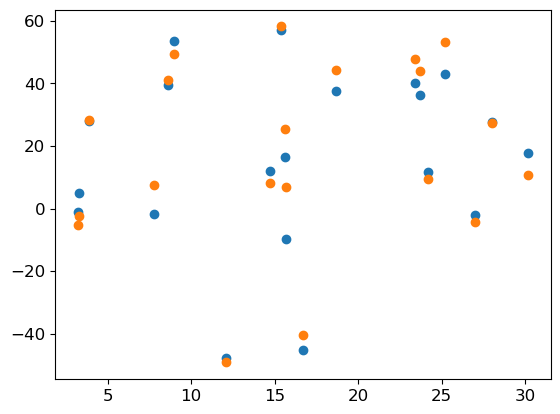

In [21]:
plt.scatter(np.array(injected.x), injected.y)
plt.scatter(np.array(injected.x), q_inj[1])

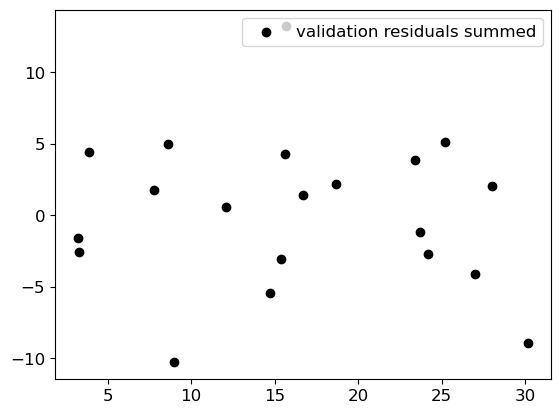

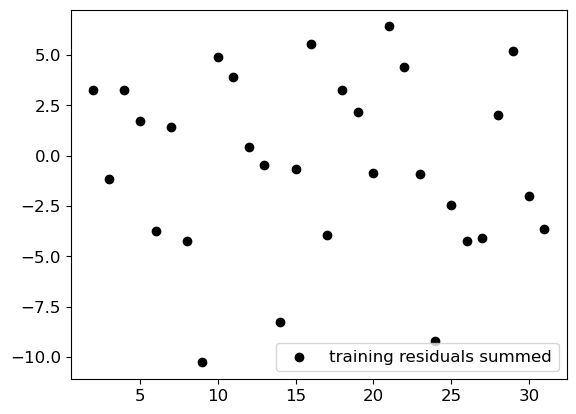

In [399]:
#plt.scatter(np.array(injected.x), res_injected, label='validation residuals', c='r')
plt.scatter(np.array(injected.x), res_planet_injected + res_star_injected - res_injected, label='validation residuals summed', c='k')
plt.legend()
plt.show()

#plt.scatter(np.array(not_injected.x), res_training, label='training residuals', c='r')
plt.scatter(np.array(not_injected.x), res_planet_training+res_star_training - res_training, label='training residuals summed', c='k')
plt.legend()
plt.show()

That looks really good; as expected, we miss some of the injected (red) points, because we never showed them to the GP. Now, let's quantitatively show that the spread on the residuals for the injected points is indeed larger than the vanilla strategy (we call these the "training" points). We should expect that observing every other day, which gaspery predicts should have larger spread, should, well, have larger spread in both injected and training points' residuals.

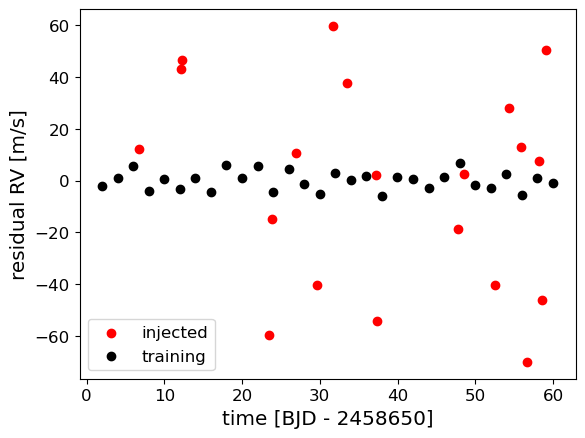

injected:  38.725701528858046
regular strategy:  3.5060701109008154


In [218]:
plt.scatter(np.array(injected.x), np.array(injected.y) - q_injected[1], label='injected', color='r')
plt.scatter(np.array(not_injected.x), np.array(not_injected.y) - preds[1], label='training', color='k')
plt.xlabel("time [BJD - 2458650]")
plt.ylabel("residual RV [m/s]")
plt.legend()
plt.show()

print("injected: ", np.std(np.array(injected.y) - q_injected[1]))
print("regular strategy: ", np.std(np.array(not_injected.y) - preds[1]))

Great -- the residuals for the injected points have greater spread than the strategy on which the GP is conditioned. Now we want to know: are the planet and stellar signals actually recovered by the best-fit model, and are we overfitting? 

To do this, we're going to separate the mean model from the GP model. We are following this tutorial: https://tinygp.readthedocs.io/en/latest/tutorials/means.html

In [219]:
def build_gp(params, t):
    sigma_qp_rv = params['sigma_qp_rv']
    Prot = params['Prot']
    Tau = params['Tau']
    eta = params['eta']
    
    kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
    kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
    kernel *= sigma_qp_rv**2 # multiply by scalar

    def mean_function(t):
        """
        Mean model is the planet's Keplerian.
        """

        return -mean_params['K'] * jnp.sin(2 * jnp.pi * (t - mean_params['T0']) / mean_params['p'])
    
    gp = GaussianProcess(kernel, t, diag=yerr**2, mean=mean_function) # mean_function
    
    return gp

@jax.jit
def loss(params):
    gp = build_gp(params, np.array(not_injected.x))
    return -gp.log_probability(y)

params = dict(
    sigma_qp_rv = sigma_qp_rv,
    Prot = Prot,
    Tau=Tau,
    eta=eta,
    **mean_params
)

loss(params)

Array(123.54795368, dtype=float64)

Minimize loss

In [220]:
import jaxopt

solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(jax.tree_util.tree_map(jnp.asarray, params))
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 122.31490945468884


Plot conditional distribution

/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_807/2374771282.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(np.array(injected.x), np.array(injected.y), yerr, fmt=".k", color='r', capsize=0, label="injected data")


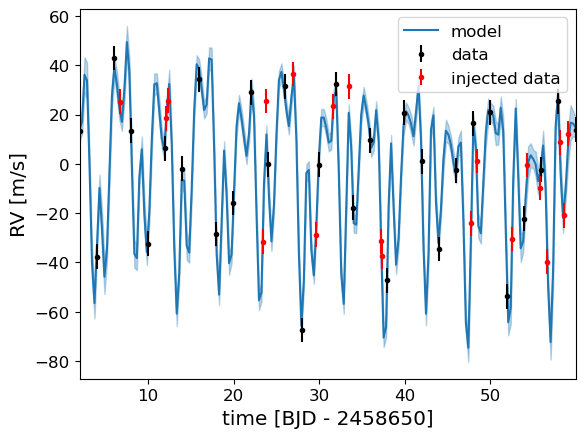

In [221]:
gp = build_gp(soln.params, np.array(not_injected.x))
y = np.array(not_injected.y)
X_grid = np.linspace(X[0], X[-1], 200)
_, cond = gp.condition(y, X_grid)

mu = cond.loc
std = np.sqrt(cond.variance)

#plt.plot(X, y, ".k", label="fake data")
plt.plot(X_grid, mu, label="model")
plt.fill_between(X_grid, mu + std, mu - std, color="C0", alpha=0.3)
plt.errorbar(X, y, yerr, fmt=".k", capsize=0, label="data")
plt.errorbar(np.array(injected.x), np.array(injected.y), yerr, fmt=".k", color='r', capsize=0, label="injected data")

plt.xlim(X_grid.min(), X_grid.max())
plt.xlabel("time [BJD - 2458650]")
plt.ylabel("RV [m/s]")

_ = plt.legend()

Separate mean model from GP predictions

/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_807/1200281380.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax1.errorbar(np.array(injected.x), np.array(injected.star), yerr, fmt=".k", color='r', capsize=0, label="injected star data")
/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_807/1200281380.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax3.errorbar(np.array(injected.x), res_star_injected,  yerr, fmt=".k", capsize=0, label='injected star', color='r')
/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_807/1200281380.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax3.errorbar(np.array(not_injected.x),

std stellar residuals:  3.424041476740365
std stellar residuals, injected:  3.4461407445839356
std planet residuals:  1.205525673855668e-14
std planet residuals, injected:  3.65234690401765e-15


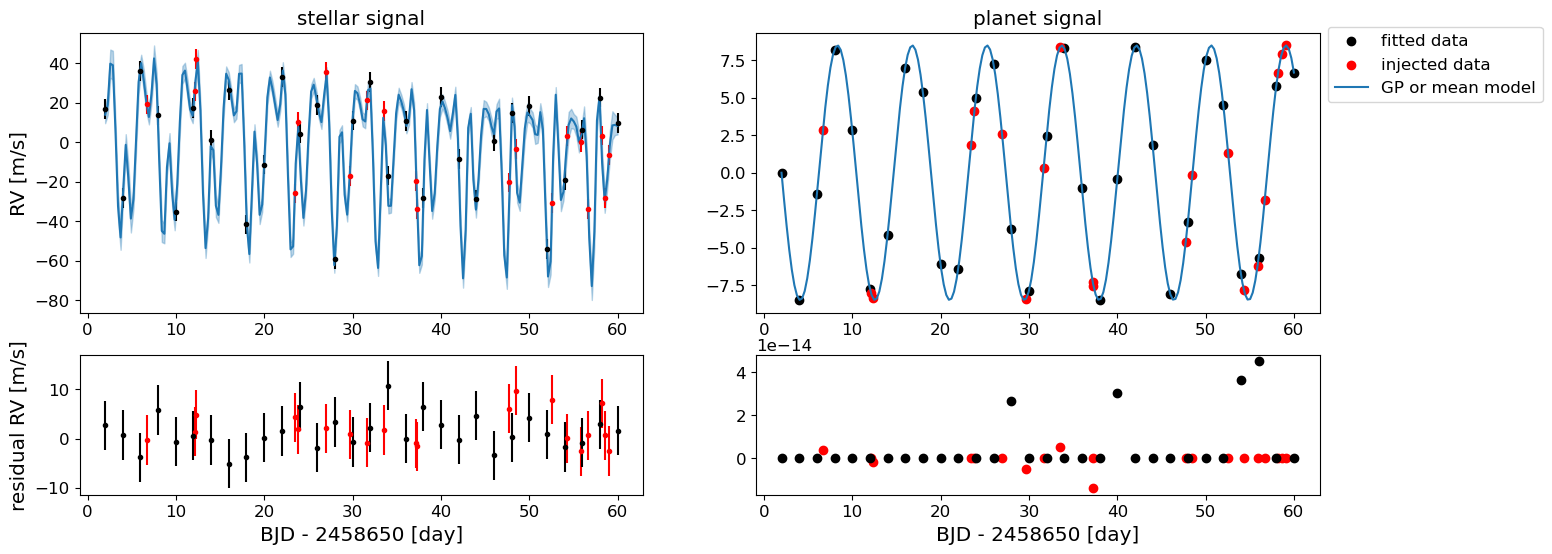

In [222]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 6), height_ratios=[1, 0.5])

### compute inferences
gp = build_gp(soln.params, np.array(not_injected.x))
_, cond = gp.condition(y, X_grid, include_mean=False) # compute conditional distribution without the mean function
_, cond_residual = gp.condition(y, np.array(not_injected.x), include_mean=False) # same but for residuals
_, cond_residual_injected = gp.condition(y, np.array(injected.x), include_mean=False) # same but for residuals

mu = cond.loc #+ soln.params["K"] # add mean model's zero point offset
mu_residual = cond_residual.loc #+ soln.params["K"]
mu_residual_injected = cond_residual_injected.loc #+ soln.params["K"]
std = np.sqrt(cond.variance)
std_residual = np.sqrt(cond_residual.variance)
std_residual_injected = np.sqrt(cond_residual_injected.variance)

### plotting
# star
ax1.errorbar(X, np.array(not_injected.star), yerr, fmt=".k", capsize=0, label="star data")
ax1.errorbar(np.array(injected.x), np.array(injected.star), yerr, fmt=".k", color='r', capsize=0, label="injected star data")
ax1.plot(X_grid, mu, label="GP model")
ax1.fill_between(X_grid, mu + std, mu - std, color="C0", alpha=0.3)
ax1.set_ylabel("RV [m/s]")
ax1.set_title("stellar signal")

# star residuals
res_star_injected = injected.star - mu_residual_injected
res_star_training = not_injected.star - mu_residual
ax3.errorbar(np.array(injected.x), res_star_injected,  yerr, fmt=".k", capsize=0, label='injected star', color='r')
ax3.errorbar(np.array(not_injected.x), res_star_training,  yerr, fmt=".k", capsize=0, label='training star', color='k')
ax3.set_xlabel("BJD - 2458650 [day]")
ax3.set_ylabel("residual RV [m/s]")
print("std stellar residuals: ", np.std(res_star_training))
print("std stellar residuals, injected: ", np.std(res_star_injected))

# planet
ax2.scatter(X, np.array(not_injected.planet), color='k', label="fitted data")
ax2.scatter(np.array(injected.x), np.array(injected.planet), color='r', label="injected data")
ax2.plot(X_grid, jax.vmap(gp.mean_function)(X_grid), label="GP or mean model")
ax2.set_title("planet signal")
ax2.legend(bbox_to_anchor=(1., 1.05))

# planet residuals 
res_planet_injected = injected.planet - jax.vmap(gp.mean_function)(np.array(injected.x))
res_planet_training = not_injected.planet - jax.vmap(gp.mean_function)(np.array(not_injected.x))
ax4.scatter(np.array(injected.x), res_planet_injected, label='injected planet', color='r')
ax4.scatter(np.array(not_injected.x), res_planet_training, label='training planet', color='k')
ax4.set_xlabel("BJD - 2458650 [day]")
#ax4.legend(bbox_to_anchor=(1., 1.05))
print("std planet residuals: ", np.std(res_planet_training))
print("std planet residuals, injected: ", np.std(res_planet_injected))

#plt.tight_layout()
plt.show()


Now that we've split into planet and star, let's look at the residuals again.

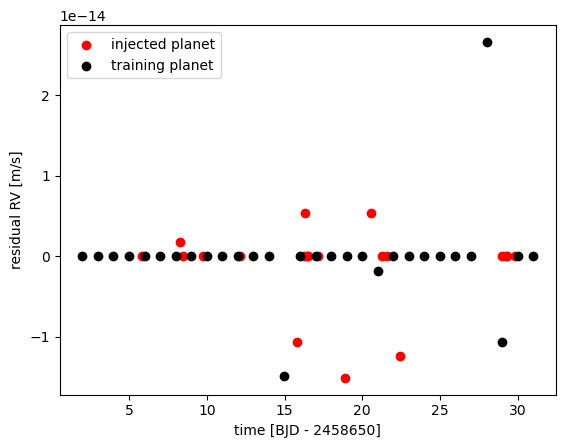

injected planet:  5.113586496365685e-15
regular strategy planet:  5.91054488534607e-15


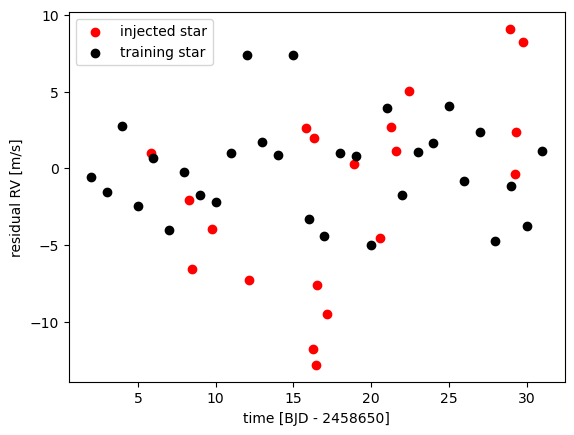

injected star:  6.069948787665106
regular strategy star:  3.1416286983177124


In [102]:
#gp_plot = build_gp(soln.params, np.array(injected_df.x))
#gp_injected = build_gp(soln.params, np.array(injected.x))

### planet 
res_planet_injected = injected.planet - jax.vmap(gp.mean_function)(np.array(injected.x))
res_planet_training = not_injected.planet - jax.vmap(gp.mean_function)(np.array(not_injected.x))
plt.scatter(np.array(injected.x), res_planet_injected, label='injected planet', color='r')
plt.scatter(np.array(not_injected.x), res_planet_training, label='training planet', color='k')
plt.xlabel("time [BJD - 2458650]")
plt.ylabel("residual RV [m/s]")
plt.legend()
plt.show()

print("injected planet: ", np.std(res_planet_injected))
print("regular strategy planet: ", np.std(res_planet_training))

### star
res_star_injected = injected.star - mu_residual_injected
res_star_training = not_injected.star - mu_residual
plt.scatter(np.array(injected.x), np.array(injected.y) - q_injected[1], label='injected star', color='r')
plt.scatter(np.array(not_injected.x), np.array(not_injected.y) - preds[1], label='training star', color='k')

plt.xlabel("time [BJD - 2458650]")
plt.ylabel("residual RV [m/s]")
plt.legend()
plt.show()

print("injected star: ", np.std(np.array(injected.y) - q_injected[1]))
print("regular strategy star: ", np.std(np.array(not_injected.y) - preds[1]))

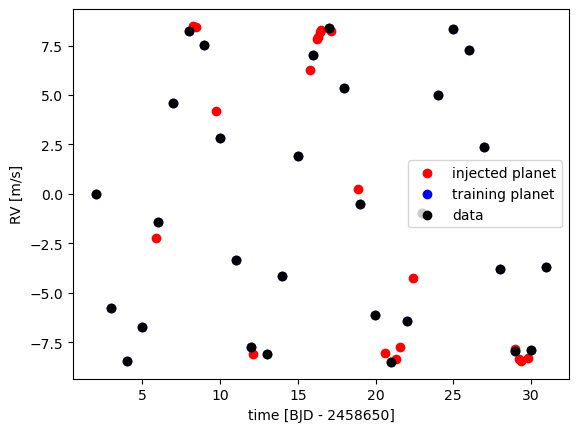

In [96]:
plt.scatter(np.array(injected.x), jax.vmap(gp.mean_function)(np.array(injected.x)), c='r', label='injected planet')
plt.scatter(np.array(not_injected.x), jax.vmap(gp.mean_function)(np.array(not_injected.x)), c='blue', label='training planet')
plt.scatter(np.array(not_injected.x), not_injected.planet, label='data', color='k')

plt.xlabel("time [BJD - 2458650]")
plt.ylabel("RV [m/s]")
plt.legend()
plt.show()

To be clear, these residuals are for the planet and stellar injected/training signals when the planet and stellar signals are split up before 

### Deprecated cells below

In [394]:
### sample from best-fit planet posteriors
best_fit_planet = np.array([data.posterior.data_vars['K'].mean(), data.posterior.data_vars['P'].mean(), 
            data.posterior.data_vars['T0'].mean()])
best_fit_planet_std = np.array([data.posterior.data_vars['K'].std(), data.posterior.data_vars['P'].std(), 
            data.posterior.data_vars['T0'].std()])

planet_k = random.normal(best_fit_planet[0], best_fit_planet_std[0], 10)
planet_p = random.normal(best_fit_planet[1], best_fit_planet_std[1], 10)
planet_t0 = random.normal(best_fit_planet[2], best_fit_planet_std[2], 10)

planets = []
for i in range(10):
    planet = calculate_fi.model_jax(np.array(injected_df.x), [planet_k[i], planet_p[i], planet_t0[i]])
    planets.append(planet)


/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_1506/2922566259.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax1.errorbar(not_injected.x, not_injected.planet, yerr, fmt=".k", capsize=0, color='k', label='planet training data')
/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_1506/2922566259.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax1.errorbar(injected.x, injected.planet, yerr, fmt=".k", capsize=0, color='r', label='planet injected data')
/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_1506/2922566259.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax3.errorbar(not_injected.x, observed_mean_planet

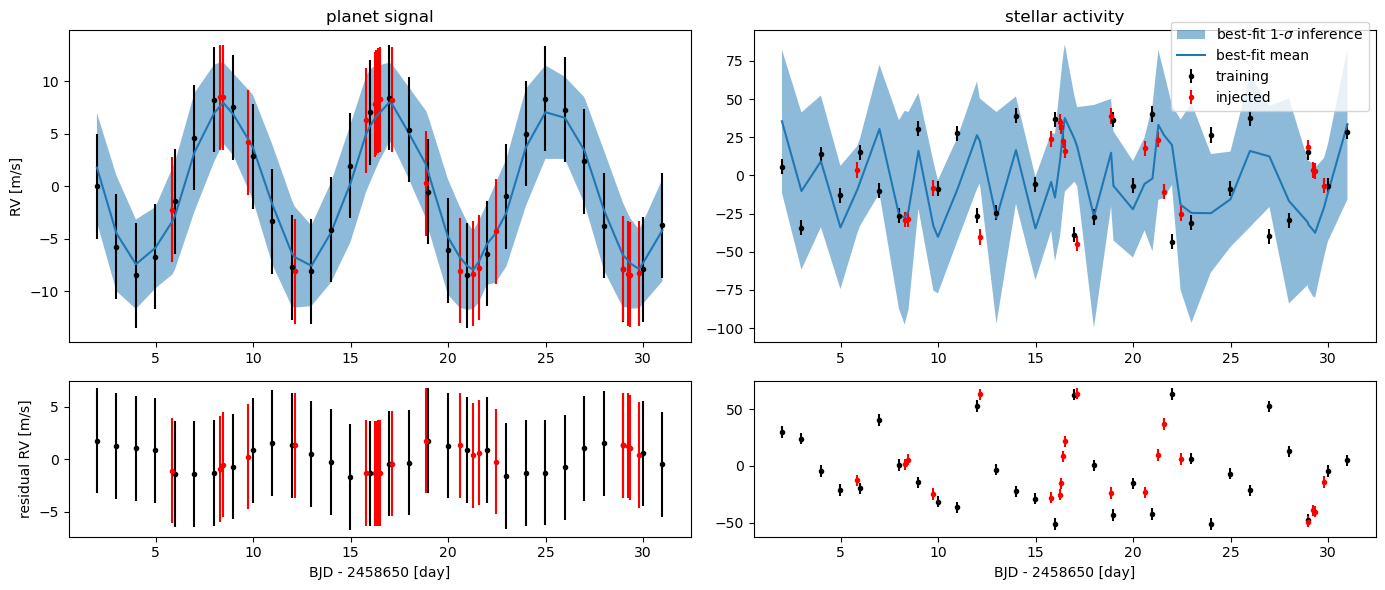

In [395]:
def mean_function_inference(params, X):
    
    return -params[0] * np.sin(2 * np.pi * (X - params[2]) / params[1])

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 6), height_ratios=[1, 0.5])

### best-fit 
#best_fit_planet = np.array([data.posterior.data_vars['K'].mean(), data.posterior.data_vars['P'].mean(), 
#            data.posterior.data_vars['T0'].mean()])
#best_fit_planet_std = np.array([data.posterior.data_vars['K'].std(), data.posterior.data_vars['P'].std(), 
#            data.posterior.data_vars['T0'].std()])
best_fit_star = np.array([sigma_qp_rv, Prot, Tau, eta])

# simulate stellar signal
kernel = kernels.ExpSineSquared(scale=best_fit_star[1], gamma=1/(2*best_fit_star[3]**2)) 
kernel *= kernels.ExpSquared(scale=best_fit_star[2]) 
kernel *= (best_fit_star[0])**2 

# instantiate GP object based on stellar activity kernel and strategy
gp = GaussianProcess(kernel, np.array(injected_df.x))

# draw ten stellar and planet signals based on best-fit parameters
sample = gp.sample(jax.random.PRNGKey(4), shape=(10,)) 

# normalize each sample to 0
sample_list = []
for i in sample:
    sample_list.append(i - np.mean(i))
sample = np.array(sample_list)
    
# add sampled planet signal and white noise
observed = sample + np.array(planets) + random.normal(0, sigma_wn_rv, len(planet))
observed_min = observed.min(axis=0)
observed_max = observed.max(axis=0)
observed_min_planet = np.array(planets).min(axis=0)
observed_max_planet = np.array(planets).max(axis=0)
observed_mean_planet = np.mean([observed_min_planet, observed_max_planet], axis=0)
observed_16_planet = observed_mean_planet - np.array(planets).std(axis=0)
observed_84_planet = observed_mean_planet + np.array(planets).std(axis=0)

observed_min_star = np.array(sample).min(axis=0)
observed_max_star = np.array(sample).max(axis=0)
observed_mean_star = np.mean([observed_min_star, observed_max_star], axis=0)
observed_16_star = observed_mean_star - np.array(sample).std(axis=0)
observed_84_star = observed_mean_star + np.array(sample).std(axis=0)

observed_mean_star = np.mean([np.array(sample).min(axis=0), np.array(sample).max(axis=0)], axis=0)

### planet
# injected signal used to generate data 
ax1.errorbar(not_injected.x, not_injected.planet, yerr, fmt=".k", capsize=0, color='k', label='planet training data')
ax1.errorbar(injected.x, injected.planet, yerr, fmt=".k", capsize=0, color='r', label='planet injected data')
# plot best-fit planet posteriors 
ax1.fill_between(np.array(injected_df.x), observed_min_planet, observed_max_planet, label="planet best-fit", alpha=0.5)
ax1.plot(np.array(injected_df.x), observed_mean_planet, label='best-fit mean')

#ax1.set_xlabel("BJD - 2458650 [day]")
ax1.set_ylabel("RV [m/s]")
#ax1.legend(bbox_to_anchor=(1.35, 1.05))
_ = ax1.set_title("planet signal")

### planet residual
### separate sample_mean into training and injected
injected_df['sample_planet_mean'] = observed_mean_planet
observed_mean_planet_training = injected_df.loc[injected_df.x.isin(strat)]['sample_planet_mean']
observed_mean_planet_injected = injected_df.loc[~injected_df.x.isin(strat)]['sample_planet_mean']

ax3.errorbar(not_injected.x, observed_mean_planet_training - not_injected.planet, 
             yerr, fmt=".k", capsize=0, color='black', label='residual training')
ax3.errorbar(injected.x, observed_mean_planet_injected - injected.planet, 
             yerr, fmt=".k", capsize=0, color='red', label='residual injected')
ax3.set_xlabel("BJD - 2458650 [day]")
ax3.set_ylabel("residual RV [m/s]")


### star
# injected signal used to generate data 
#ax2.plot(X, sample[0], label="star data", alpha=0.5, color="green")
ax2.errorbar(not_injected.x, not_injected.star - np.mean(injected_df.y), yerr, fmt=".k", capsize=0, color='k', label='training')
ax2.errorbar(injected.x, injected.star - np.mean(injected_df.y), yerr, fmt=".k", capsize=0, color='r', label='injected')
# plot best-fit star posteriors 
ax2.fill_between(np.array(injected_df.x), observed_16_star, observed_84_star, 
                 label=r"best-fit 1-$\sigma$ inference", alpha=0.5)
ax2.plot(np.array(injected_df.x), observed_mean_star, label='best-fit mean')

#ax2.set_ylabel("RV [m/s]")
ax2.legend(bbox_to_anchor=(1., 1.05))
_ = ax2.set_title("stellar activity")


### star residual
### separate sample_mean into training and injected
injected_df['sample_star_mean'] = observed_mean_star
observed_mean_star_training = injected_df.loc[injected_df.x.isin(strat)]['sample_star_mean']
observed_mean_star_injected = injected_df.loc[~injected_df.x.isin(strat)]['sample_star_mean']

#ax4.errorbar(injected_df.x, observed_mean_star - injected_df.star, 
#             yerr, fmt=".k", capsize=0, color='blue', label='residual')
ax4.errorbar(not_injected.x, observed_mean_star_training - (not_injected.star - np.mean(injected_df.y)), 
             yerr, fmt=".k", capsize=0, color='black', label='residual training')
ax4.errorbar(injected.x, observed_mean_star_injected - (injected.star - np.mean(injected_df.y)), 
             yerr, fmt=".k", capsize=0, color='red', label='residual injected')
ax4.set_xlabel("BJD - 2458650 [day]")

plt.tight_layout()
#plt.savefig(path+'plots/comparison_bad.png')
plt.show()

Ope, these are samples of the posteriors, not the best fit conditioned on the data. I mean, they are informed in some way by the data, since they're different from the priors, but these are not the best fits we want. 

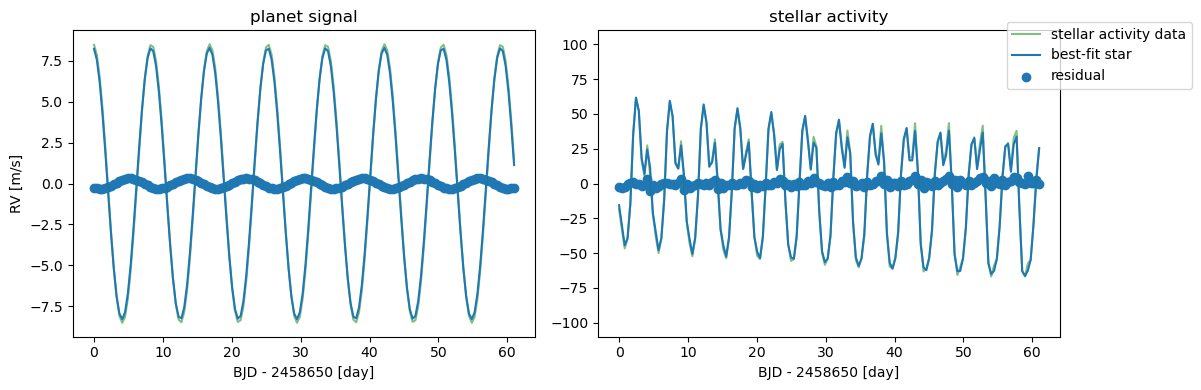

In [129]:
def mean_function_inference(params, X):
    
    return -params[0] * jnp.sin(2 * jnp.pi * (X - params[2]) / params[1])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

q = np.percentile(preds, [5, 50, 95], axis=0)

### planet
# injected signal used to generate data 
ax1.plot(t_plot, planet_plot, label="Keplerian data", alpha=0.5, color="green")
#ax1.plot(X, planet, label="Keplerian data", alpha=0.5, color="green")

# best-fit 
best_fit = np.array([data.posterior.data_vars['K'].mean(), data.posterior.data_vars['P'].mean(), 
            data.posterior.data_vars['T0'].mean()])
ax1.plot(t_plot, mean_function_inference(best_fit, t_plot), label="best-fit planet")
ax1.scatter(t_plot, mean_function_inference(best_fit, t_plot) - planet_plot, label='residual')
#ax1.plot(X, mean_function_inference(best_fit, X), label="best-fit")
#ax1.scatter(X, mean_function_inference(best_fit, X) - planet, label='residual')

ax1.set_xlabel("BJD - 2458650 [day]")
ax1.set_ylabel("RV [m/s]")
#ax1.legend(bbox_to_anchor=(1.35, 1.05))
_ = ax1.set_title("planet signal")

### star
# injected signal used to generate data 
ax2.plot(t_plot, sample_plot[0], label="stellar activity data", alpha=0.5, color="green")
#ax2.plot(X, sample[0], label="data", alpha=0.5, color="green")

# best-fit 
ax2.plot(t_plot, q[1] - mean_function_inference(best_fit, t_plot), label="best-fit star")
ax2.scatter(t_plot, sample_plot[0] - (q[1] - mean_function_inference(best_fit, t_plot)), label='residual')
#ax2.plot(X, q[1] - mean_function_inference(best_fit, X), label="best-fit")
#ax2.scatter(X, sample[0] - (q[1] - mean_function_inference(best_fit, X)), label='residual')

ax2.set_xlabel("BJD - 2458650 [day]")
ax2.set_ylim([-110, 110])
#ax2.set_ylabel("RV [m/s]")
ax2.legend(bbox_to_anchor=(1.3, 1.05))
_ = ax2.set_title("stellar activity")

plt.tight_layout()
plt.savefig(path+'plots/comparison_bad_150.png')
plt.show()

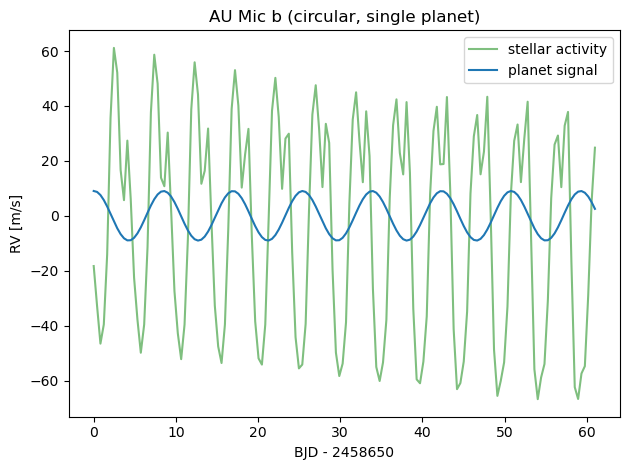

In [161]:
plt.plot(t_plot, sample_plot[0], label="stellar activity", alpha=0.5, color="green")
plt.plot(t_plot, mean_function_inference(best_fit, t_plot), label="planet signal")
plt.xlabel("BJD - 2458650")
plt.ylabel("RV [m/s]")
plt.legend()
plt.title("AU Mic b (circular, single planet)")
plt.tight_layout()
plt.savefig(path+"plots/comparison_for_slides.png", format='png')
plt.show()

Let's plot the residuals (data minus GP best-fit)

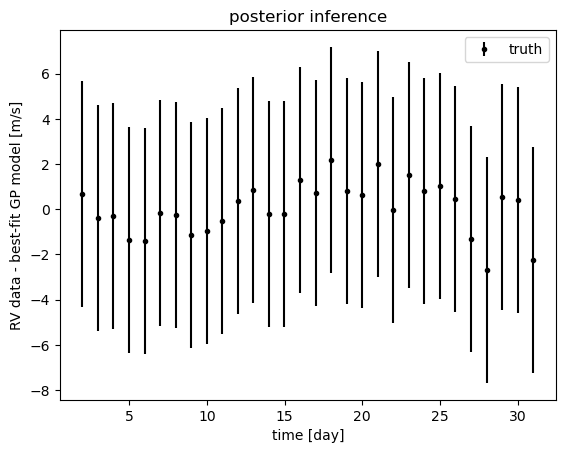

In [210]:
q = np.percentile(preds, [5, 50, 95], axis=0)
#plt.fill_between(X, q[0], q[2], color="C0", alpha=0.5, label="inference")
#plt.plot(X, q[1], color="C0", lw=2)

plt.errorbar(X, y - q[1], yerr,
             fmt=".k", capsize=0)
plt.xlabel("time [day]")
plt.ylabel("RV data - best-fit GP model [m/s]")
plt.legend()
_ = plt.title("posterior inference")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


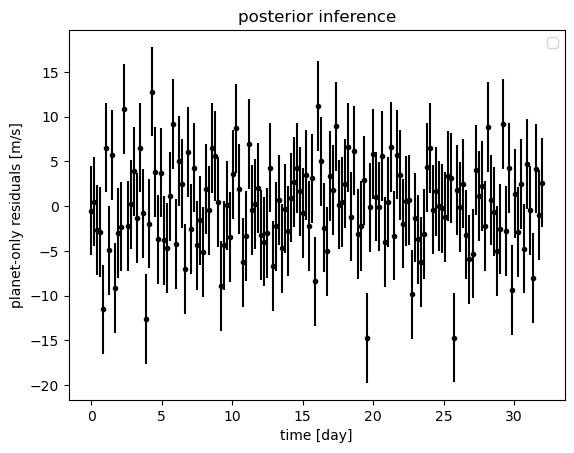

In [23]:
q_plot = np.percentile(preds_plot, [5, 50, 95], axis=0)
#plt.fill_between(t_plot, q_plot[0], q_plot[2], color="C0", alpha=0.5, label="inference")
#plt.plot(t_plot, q_plot[1], color="C0", lw=2)

plt.errorbar(t_plot, y_plot - q_plot[1], yerr,
             fmt=".k", capsize=0)
plt.xlabel("time [day]")
plt.ylabel("planet-only residuals [m/s]")
plt.legend()
_ = plt.title("posterior inference")